In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!wget https://raw.githubusercontent.com/Illalla/helper_functions_for_tf/main/helper_functions.py
from helper_functions import *

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d berkayalan/microsoft-stock-data-between-2015-and-2022

In [5]:
import zipfile
zip_ref = zipfile.ZipFile('/content/microsoft-stock-data-between-2015-and-2022.zip')
zip_ref.extractall()
zip_ref.close()

In [6]:
df = pd.read_csv('microsoft_stocks.csv', parse_dates=['Date'], usecols=['Date', 'Close'], index_col=['Date']).rename(columns={'Close': 'Price'})
df.head()

,Price
Date,
2015-01-12,46.599998
2015-01-13,46.360001
2015-01-14,45.959999
2015-01-15,45.480000
2015-01-16,46.240002


In [7]:
dates, prices = df.index, df.Price

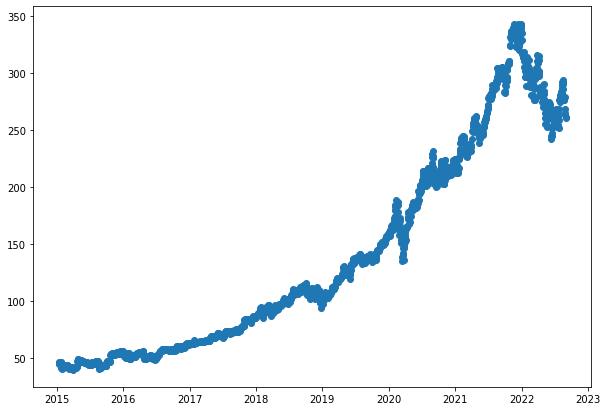

In [8]:
fig, ax = plt.subplots(figsize=(10, 7))
scatter = ax.scatter(dates, prices)
plt.show();

In [9]:
def make_train_test_split(data, split_factor=0.8):
  split_index = int(0.8 * len(data))
  return data[:split_index], data[split_index:]

In [10]:
dates, prices = df.index, df.Price

In [11]:
train_prices, test_prices = make_train_test_split(prices)
train_dates, test_dates = make_train_test_split(dates)

In [12]:
len(train_dates), len(test_dates)

(1540, 385)

### Naive "Model"

In [13]:
pred_0 = test_prices[:-1]

In [14]:
naive_scores = forecasting_scores(y_true=test_prices[1:], y_pred=pred_0)
naive_scores

{'mae': 3.6687243,
 'mse': 23.314003,
 'rmse': 4.8284574,
 'mape': 1.3065732,
 'mase': 1.0013479}

### Windows and horizons

In [15]:
train_windowsW7H1, train_targetsW7H1 = windows_and_horizons(train_prices, 1, 7)
test_windowsW7H1, test_targetsW7H1 = windows_and_horizons(test_prices, 1, 7)
train_dataW7H1 = tf.data.Dataset.from_tensor_slices((train_windowsW7H1, train_targetsW7H1)).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataW7H1 = tf.data.Dataset.from_tensor_slices((test_windowsW7H1, test_targetsW7H1)).batch(32).prefetch(tf.data.AUTOTUNE)

### Dense model (model 1)

In [16]:
from tensorflow.keras import layers
model_1 = tf.keras.Sequential([
    layers.Dense(100, activation='relu'),
    layers.Dense(100, activation='relu'),
    layers.Dense(1)
])

model_1.compile(loss='mae', optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.01))

In [17]:
def model_checkpoint(filepath):
  return tf.keras.callbacks.ModelCheckpoint(filepath, save_best_only=True, save_weights_only=True)

In [18]:
model_1.fit(train_dataW7H1, epochs=50, validation_data=test_dataW7H1,
            callbacks=[model_checkpoint('experiments/model_1(dense)')])

Epoch 1/50
48/48 [==============================] - 3s 6ms/step - loss: 99.5302 - val_loss: 250.5031
Epoch 2/50
48/48 [==============================] - 0s 3ms/step - loss: 83.0837 - val_loss: 203.5667
Epoch 3/50
48/48 [==============================] - 0s 3ms/step - loss: 61.5553 - val_loss: 114.7300
Epoch 4/50
48/48 [==============================] - 0s 3ms/step - loss: 12.0495 - val_loss: 7.1129
Epoch 5/50
48/48 [==============================] - 0s 3ms/step - loss: 2.3158 - val_loss: 7.1158
Epoch 6/50
48/48 [==============================] - 0s 3ms/step - loss: 2.2751 - val_loss: 7.0609
Epoch 7/50
48/48 [==============================] - 0s 3ms/step - loss: 2.2401 - val_loss: 7.0325
Epoch 8/50
48/48 [==============================] - 0s 3ms/step - loss: 2.2037 - val_loss: 6.8310
Epoch 9/50
48/48 [==============================] - 0s 3ms/step - loss: 2.1586 - val_loss: 6.7204
Epoch 10/50
48/48 [==============================] - 0s 3ms/step - loss: 2.1312 - val_loss: 6.7642
Epoch 11/

In [19]:
model_1.load_weights('experiments/model_1(dense)')

In [20]:
pred_1 = model_1.predict(test_dataW7H1)
model_1_scores = forecasting_scores(test_targetsW7H1, pred_1)

12/12 [==============================] - 0s 2ms/step


In [21]:
model_1_scores

{'mae': 5.987096,
 'mse': 60.645115,
 'rmse': 7.787497,
 'mape': 2.1200323,
 'mase': 1.6353682}

In [22]:
def plotting_function(timesteps, values, start=0, end=None, format='.', label=None):
  plt.plot(timesteps[start: end], values[start: end], format, label=label)
  plt.xlabel('Time')
  plt.ylabel('Values')
  if label:
    plt.legend(fontsize=10)
  plt.grid(True)

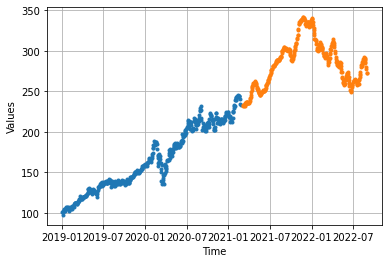

In [23]:
plotting_function(train_dates, train_prices, start=1000)
plotting_function(test_dates[7:], pred_1)

### LSTM (model_2)

In [24]:
model_2 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # LSTM needs ndim=3
    layers.LSTM(64, activation='relu', return_sequences=True),
    layers.LSTM(64, activation='relu'),
    layers.Dense(1)
])

model_2.compile(loss='mae', optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.01))

In [25]:
model_2.fit(train_dataW7H1, epochs=50, validation_data=test_dataW7H1, callbacks=[model_checkpoint('experiments/model_2(LSTM)')], verbose=0)

In [26]:
model_2.load_weights('experiments/model_2(LSTM)')
pred_2 = model_2.predict(test_dataW7H1)
model_2_scores = forecasting_scores(test_targetsW7H1, pred_2)
model_2_scores

12/12 [==============================] - 0s 2ms/step


{'mae': 5.7943954,
 'mse': 56.75554,
 'rmse': 7.533627,
 'mape': 2.04934,
 'mase': 1.5827323}

#### Let's try training it for longer


In [27]:
model_2.fit(train_dataW7H1, epochs=100, validation_data=test_dataW7H1, callbacks=[model_checkpoint('experiments/model_2(LSTM)')], verbose=0)

In [28]:
model_2.load_weights('experiments/model_2(LSTM)')
pred_2 = model_2.predict(test_dataW7H1)
model_2_scores = forecasting_scores(test_targetsW7H1, pred_2)
model_2_scores

12/12 [==============================] - 0s 2ms/step


{'mae': 4.332264,
 'mse': 31.904888,
 'rmse': 5.6484413,
 'mape': 1.5373024,
 'mase': 1.1833528}

As we can see, it got better but it's debatable if additional 100 epochs are worth it.

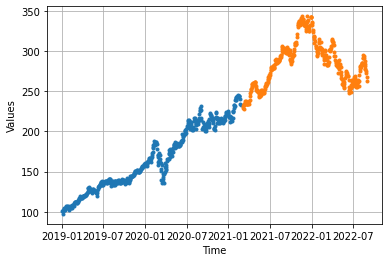

In [29]:
plotting_function(train_dates, train_prices, start=1000)
plotting_function(test_dates[7:], pred_2)

### Model 3 (bi-lstm)

In [30]:
model_3 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    layers.Bidirectional(layers.LSTM(64, activation='relu', return_sequences=True)),
    layers.Bidirectional(layers.LSTM(64, activation='relu')),
    layers.Dense(1)
])

model_3.compile(loss='mae', optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.01))

In [31]:
model_3.fit(train_dataW7H1, epochs=50, validation_data=test_dataW7H1, callbacks=[model_checkpoint('experiments/model_3(biLSTM)')], verbose=0)

In [32]:
model_3.load_weights('experiments/model_3(biLSTM)')
pred_3 = model_3.predict(test_dataW7H1)
model_3_scores = forecasting_scores(test_targetsW7H1, pred_3)
model_3_scores

12/12 [==============================] - 0s 3ms/step


{'mae': 4.5349574,
 'mse': 33.89989,
 'rmse': 5.8223615,
 'mape': 1.6013805,
 'mase': 1.2387183}

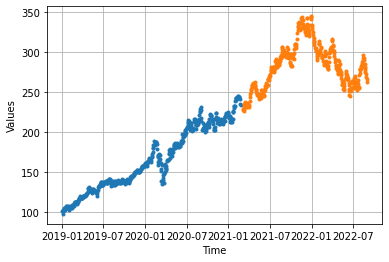

In [33]:
plotting_function(train_dates, train_prices, start=1000)
plotting_function(test_dates[7:], pred_3)

### Model 4 (NBEATS)

In [34]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size,
               theta_size,
               horizon,
               hidden_layers,
               neurons,
               **kwargs):
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.hidden_layers = hidden_layers
    self.neurons = neurons
  
    self.hidden = [layers.Dense(neurons, activation='relu') for _ in range(hidden_layers)]
    self.theta = layers.Dense(theta_size)
  
  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta(x)
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [35]:
dummy_layer = NBeatsBlock(7, 8, 1, 5, 30)

In [36]:
dummy_window = tf.expand_dims(tf.range(7), axis=0)
dummy_layer(dummy_window)

(<tf.Tensor: shape=(1, 7), dtype=float32, numpy=
 array([[ 0.30088335, -0.40553364,  0.35618967, -0.36313096, -0.20252956,
          0.05730916,  0.36899966]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.08801168]], dtype=float32)>)

In [37]:
def create_NBeatsModel(window_size,
                       horizon_size,
                       hidden_layers,
                       blocks,
                       neurons):
  inputs = layers.Input(shape=(7,))
  backcast, forecast = NBeatsBlock(window_size,
                                   horizon_size+window_size,
                                   horizon_size,
                                   hidden_layers,
                                   neurons)(inputs)
  for i in range(blocks-1):
    residuals, blockforecast = NBeatsBlock(window_size,
                                   horizon_size+window_size,
                                   horizon_size,
                                   hidden_layers,
                                   neurons)(backcast)
    backcast = layers.subtract([backcast, residuals])
    forecast = layers.add([forecast, blockforecast])

  model = tf.keras.Model(inputs, forecast)
  return model

In [38]:
model_4 = create_NBeatsModel(7, 1, 4, 30, 256)

In [39]:
model_4.compile(loss='mae', optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.01))
model_4.fit(train_dataW7H1, epochs=200, validation_data=test_dataW7H1, callbacks=[model_checkpoint('experiments/model_4(NBEATS)'), tf.keras.callbacks.EarlyStopping(patience=500),
                                                                                   tf.keras.callbacks.ReduceLROnPlateau(patience=15)], verbose=0)

In [40]:
model_4.load_weights('experiments/model_4(NBEATS)')
pred_4 = model_4.predict(test_dataW7H1)
model_4_scores = forecasting_scores(test_targetsW7H1, pred_4)
model_4_scores

12/12 [==============================] - 1s 8ms/step


{'mae': 4.0600185,
 'mse': 28.03142,
 'rmse': 5.294471,
 'mape': 1.4403654,
 'mase': 1.1089892}

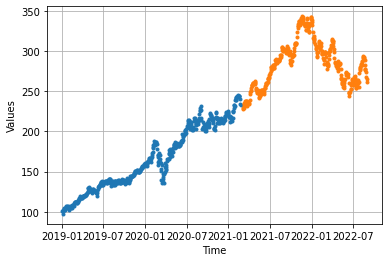

In [41]:
plotting_function(train_dates, train_prices, start=1000)
plotting_function(test_dates[7:], pred_4)

### "Model" 5 (ensemble)

In [42]:
def get_ensemble_models(horizon=1,
                        train_data=train_dataW7H1,
                        test_data=test_dataW7H1,
                        num_iter=10,
                        num_epochs=1000,
                        patience_EarlyStopping=100,
                        patience_ReduceLR=50,
                        loss_fns=['mae', 'mse', 'mape']):

  ensemble_models = []
  for i in range(num_iter):
    for loss_function in loss_fns:
      print(f'Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}')

      model = tf.keras.Sequential([
          layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
          layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
          layers.Dense(horizon)
      ])
      model.compile(loss=loss_function, optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.01), metrics=['mae', 'mse'])
      model.fit(train_data, epochs=num_epochs, validation_data=test_data, verbose=0,
                callbacks=[tf.keras.callbacks.EarlyStopping(patience=patience_EarlyStopping, restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(patience=patience_ReduceLR, verbose=0)])
      ensemble_models.append(model)
  return ensemble_models

In [43]:
ensemble_models = get_ensemble_models(num_epochs=100, patience_EarlyStopping=25, patience_ReduceLR=10)

Optimizing model by reducing: mae for 100 epochs, model number: 0
Optimizing model by reducing: mse for 100 epochs, model number: 0
Optimizing model by reducing: mape for 100 epochs, model number: 0
Optimizing model by reducing: mae for 100 epochs, model number: 1
Optimizing model by reducing: mse for 100 epochs, model number: 1
Optimizing model by reducing: mape for 100 epochs, model number: 1
Optimizing model by reducing: mae for 100 epochs, model number: 2
Optimizing model by reducing: mse for 100 epochs, model number: 2
Optimizing model by reducing: mape for 100 epochs, model number: 2
Optimizing model by reducing: mae for 100 epochs, model number: 3
Optimizing model by reducing: mse for 100 epochs, model number: 3
Optimizing model by reducing: mape for 100 epochs, model number: 3
Optimizing model by reducing: mae for 100 epochs, model number: 4
Optimizing model by reducing: mse for 100 epochs, model number: 4
Optimizing model by reducing: mape for 100 epochs, model number: 4
Optim

In [44]:
def get_ensemble_preds(data, ensemble_models):
  ensemble_preds = []
  for model in ensemble_models:
    y_pred = model.predict(data)
    ensemble_preds.append(y_pred)
  return tf.squeeze(ensemble_preds)

In [45]:
pred_5 = get_ensemble_preds(test_dataW7H1, ensemble_models)

12/12 [==============================] - 0s 2ms/step


In [46]:
pred_5_mean = np.mean(pred_5, axis=0)

In [47]:
model_5_scores = forecasting_scores(test_targetsW7H1, pred_5_mean)
model_5_scores

{'mae': 32.35334,
 'mse': 1605.4927,
 'rmse': 5.844644,
 'mape': 11.500655,
 'mase': 8.837276}

In [48]:
ensemble_models_2 = get_ensemble_models(num_epochs=100, patience_EarlyStopping=25, patience_ReduceLR=10, loss_fns=['mae', 'mape'])

Optimizing model by reducing: mae for 100 epochs, model number: 0
Optimizing model by reducing: mape for 100 epochs, model number: 0
Optimizing model by reducing: mae for 100 epochs, model number: 1
Optimizing model by reducing: mape for 100 epochs, model number: 1
Optimizing model by reducing: mae for 100 epochs, model number: 2
Optimizing model by reducing: mape for 100 epochs, model number: 2
Optimizing model by reducing: mae for 100 epochs, model number: 3
Optimizing model by reducing: mape for 100 epochs, model number: 3
Optimizing model by reducing: mae for 100 epochs, model number: 4
Optimizing model by reducing: mape for 100 epochs, model number: 4
Optimizing model by reducing: mae for 100 epochs, model number: 5
Optimizing model by reducing: mape for 100 epochs, model number: 5
Optimizing model by reducing: mae for 100 epochs, model number: 6
Optimizing model by reducing: mape for 100 epochs, model number: 6
Optimizing model by reducing: mae for 100 epochs, model number: 7
Opt

In [49]:
pred_6 = get_ensemble_preds(test_dataW7H1, ensemble_models_2)
pred_6_mean = np.mean(pred_6, axis=0)
model_6_scores = forecasting_scores(test_targetsW7H1, pred_6_mean)
model_6_scores

12/12 [==============================] - 0s 2ms/step


{'mae': 32.33158,
 'mse': 1603.4346,
 'rmse': 5.6315727,
 'mape': 11.488008,
 'mase': 8.831334}

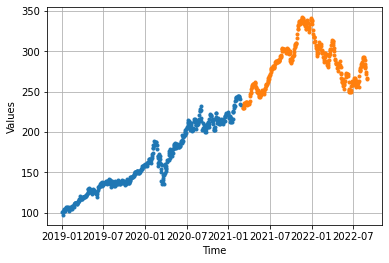

In [51]:
plotting_function(train_dates, train_prices, start=1000)
plotting_function(test_dates[7:], pred_6_mean)